# Imports

In [9]:
%load_ext autoreload
%autoreload 2

import skimage
import os
import glob
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import egg_class_functions as ecf
import tensorflow as tf
from napari_convpaint.conv_paint_model import ConvpaintModel
from skimage.util import img_as_ubyte
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from joblib import load, dump
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

importlib.reload(ecf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'egg_class_functions' from '/home/tibor/Documents/Python/mosquito-egg-identification/egg_class_functions.py'>

# Variable setup

In [3]:
seg_model = ConvpaintModel(model_path="Models/Enet_v7.pkl")
seg_class_model = load("Models/seg_ident_classifier_v3.joblib")

image_paths = sorted(glob.glob("Data/raw/microscope/**/*.*", recursive=True), key=lambda x: (os.path.dirname(x), os.path.basename(x)))
height = 2076
width = 3088


Info: Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.
Info: Ilastik is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[ilastik]' to install it.
Make sure to also have fastfilters installed ('conda install -c ilastik-forge fastfilters').


# picture import and segmentation

In [15]:
images, df = ecf.egg_image_data_import(image_paths)

In [22]:
df['name'] = df['name'].str.replace(r'\.[^.]+$', '', regex=True)

In [23]:
df

,image_path,device,species,image,name
0,Data/raw/microscope/aegypti/ag_001.tif,microscope,aegypti,"[[[192, 184, 184], [189, 183, 183], [191, 186,...",ag_001
1,Data/raw/microscope/aegypti/ag_002.tif,microscope,aegypti,"[[[22, 29, 36], [22, 27, 39], [29, 36, 49], [2...",ag_002
2,Data/raw/microscope/aegypti/ag_003.tif,microscope,aegypti,"[[[30, 46, 47], [20, 32, 41], [20, 29, 40], [2...",ag_003
3,Data/raw/microscope/aegypti/ag_004.tif,microscope,aegypti,"[[[18, 19, 27], [9, 14, 24], [15, 23, 35], [24...",ag_004
4,Data/raw/microscope/aegypti/ag_005.tif,microscope,aegypti,"[[[197, 191, 191], [201, 195, 193], [201, 195,...",ag_005
...,...,...,...,...,...
235,Data/raw/microscope/albopictus_old/ap_16.tif,microscope,albopictus_old,"[[[155, 134, 127], [155, 132, 126], [153, 128,...",ap_16
236,Data/raw/microscope/albopictus_old/ap_17.tif,microscope,albopictus_old,"[[[171, 158, 159], [175, 160, 162], [176, 161,...",ap_17
237,Data/raw/microscope/albopictus_old/ap_18.tif,microscope,albopictus_old,"[[[192, 175, 182], [193, 179, 182], [196, 186,...",ap_18
238,Data/raw/microscope/albopictus_old/ap_19.tif,microscope,albopictus_old,"[[[149, 125, 103], [159, 129, 108], [158, 126,...",ap_19


In [31]:
for row in df.itertuples():
    skimage.io.imsave(f"Data/egg_annot/{row.name}.png", row.image)

In [6]:
resize_mask = []
for i, image in enumerate(images):
    if image.shape[:2] != (height, width):
        image, content_mask = ecf.resize_with_padding(image, width, height)
        images[i] = image
    else:
        content_mask = np.ones((height, width), dtype=bool)
    resize_mask.append(content_mask)

In [ ]:
data = []
masked_images = []
masks = []
for i, image in enumerate(images):
    segment_mask = ecf.segmentation(image, seg_model)
    if image.shape[:2] != (height, width):
        segment_mask[~resize_mask[i]] = 1
    regions, labeled_overlay = ecf.region_separation(segment_mask)
    for j, region in enumerate(regions):
        masked_image, mask, parameters = ecf.region_processing(image, labeled_overlay, region)
        segment_path = f"Data/processed/segment_images/image_{i}_segment_{j}.png"
        segment_mask_path = f"Data/processed/segment_masks/image_{i}_mask_{j}.png"
        df_info = df.iloc[i].to_dict()
        combined = {**df_info, 'segment_path': segment_path, 'segment_mask_path': segment_mask_path, 'image_index': i, 'region_index': j, **parameters}
        data.append(combined)
        masked_images.append(masked_image)
        masks.append(mask)
        skimage.io.imsave(segment_path, img_as_ubyte(masked_image))
        skimage.io.imsave(segment_mask_path, img_as_ubyte(mask))
data_df = pd.DataFrame(data)
data_df.to_csv("Data/processed/segmentation_data.csv")

# Segment Classification

In [ ]:
data_old = pd.read_csv("Data/processed/segmentation_data_old.csv")
import json
with open('labels.json', 'r', encoding='utf-8') as file:
    labels = json.load(file)
data_old['json_key'] = data_old.apply(ecf.make_key, axis=1)

data_old['label'] = data_old['json_key'].map(labels)

# One-Hot-Encoding der 'label'-Spalte
label_ohe = pd.get_dummies(data_old['label'], prefix='label').astype(int)


# Die neuen Spalten an den DataFrame anh�ngen
data_old = pd.concat([data_old, label_ohe], axis=1)

# Optional: Hilfsspalten entfernen
data_old.drop(columns=['json_key', 'label'], inplace=True)


data_old

In [14]:
features = ('area', 'perimeter', 'roundness', 'length', 'width', 'len_wid_ratio', 'laplacian', 'edge')
X = data_df.loc[:, features]
# y = data_old.iloc[:, 15:]

In [17]:
y_pred = seg_class_model.predict(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell erstellen und trainieren
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 200, 500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

grid_search_forest = GridSearchCV(model, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)
grid_search_forest.fit(X, y)
best_forest_model = grid_search_forest.best_estimator_
y_pred = best_forest_model.predict(X_test)

In [52]:
y_pred = best_forest_model.predict(X)

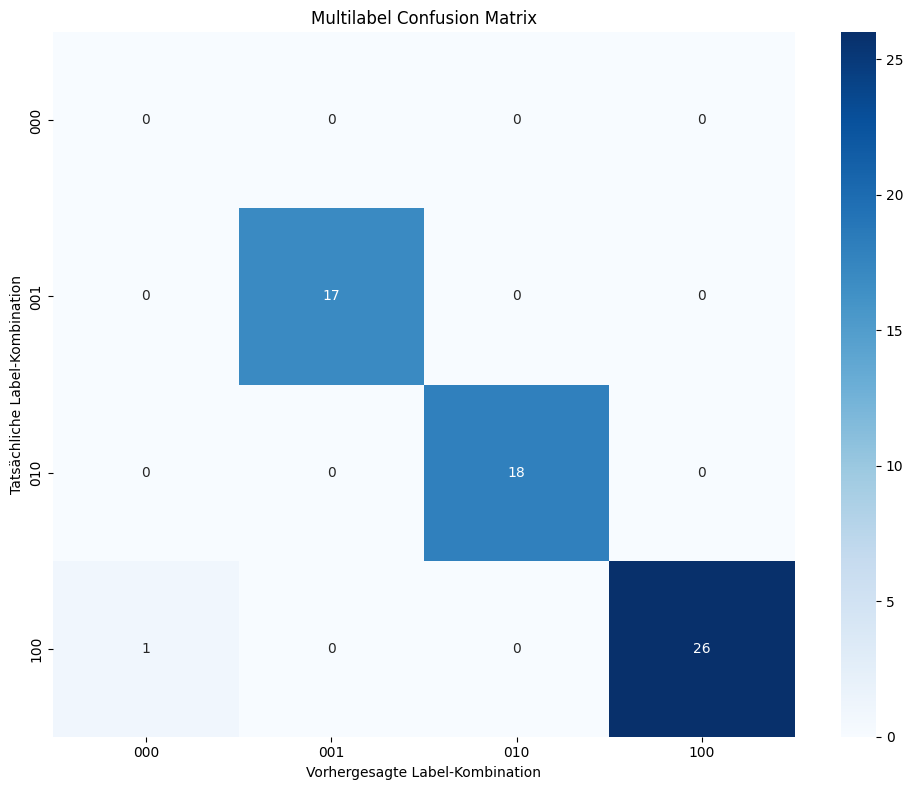

In [43]:
# Kombinierte Labels erzeugen
combined_y_test = y_test.apply(lambda row: ''.join(row.astype(str)), axis=1)
combined_y_pred = pd.DataFrame(y_pred, columns=y.columns).apply(lambda row: ''.join(row.astype(str)), axis=1)

# Confusion Matrix berechnen
conf_matrix_combined = confusion_matrix(combined_y_test, combined_y_pred)

# Labels sortieren
labels_sorted = sorted(set(combined_y_test) | set(combined_y_pred))

# Matrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Vorhergesagte Label-Kombination")
plt.ylabel("Tatsächliche Label-Kombination")
plt.title("Multilabel Confusion Matrix")
plt.tight_layout()
plt.show()

In [46]:
y_pred = best_forest_model.predict(X)

In [48]:
report = classification_report(y_test, y_pred, target_names=y.columns, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df

,precision,recall,f1-score,support
label_cut-off,1.000000,0.962963,0.981132,27.0
label_multi,1.000000,1.000000,1.000000,18.0
label_single,0.944444,1.000000,0.971429,17.0
micro avg,0.983871,0.983871,0.983871,62.0
macro avg,0.981481,0.987654,0.984187,62.0
weighted avg,0.984767,0.983871,0.983949,62.0
samples avg,0.983871,0.983871,0.983871,62.0


In [44]:
dump(best_forest_model, 'Models/seg_ident_classifier_v3.joblib')

['Models/seg_ident_classifier_v3.joblib']

In [ ]:
loaded_model = load('Models/complete_segmentation_identifier_random_forest.joblib')

In [45]:
y_pred = loaded_model.predict(X)

In [34]:
class_names = ['cut-off', 'multi', 'single']
y_pred_df = pd.DataFrame(y_pred, columns=class_names)
y_pred_df.index = data_df.index
df_pred = pd.concat([data_df, y_pred_df], axis=1)
df_pred.to_csv("Data/predicted_segmentation_data.csv", index=False)

In [ ]:
single_egg_df = df_pred.loc[df_pred["single"] == 1].reset_index(drop=True)
single_egg_df = single_egg_df.dropna()
single_egg_df["segment"] = single_egg_df.apply(ecf.rotate_and_pad_rgb_segment, axis=1)

In [ ]:
plt.imshow(df_pred.loc[1, "segment"])

In [4]:
df_pred = pd.read_csv("Data/predicted_segmentation_data.csv")

In [31]:
masked_images = []
masks = []

segment_path = sorted(glob.glob("Data/processed/segment_images/*.*", recursive=True))
mask_path = sorted(glob.glob("Data/processed/segment_masks/*.*", recursive=True))
masked_images = ecf.egg_image_import(segment_path)
masks = ecf.egg_image_import(mask_path)

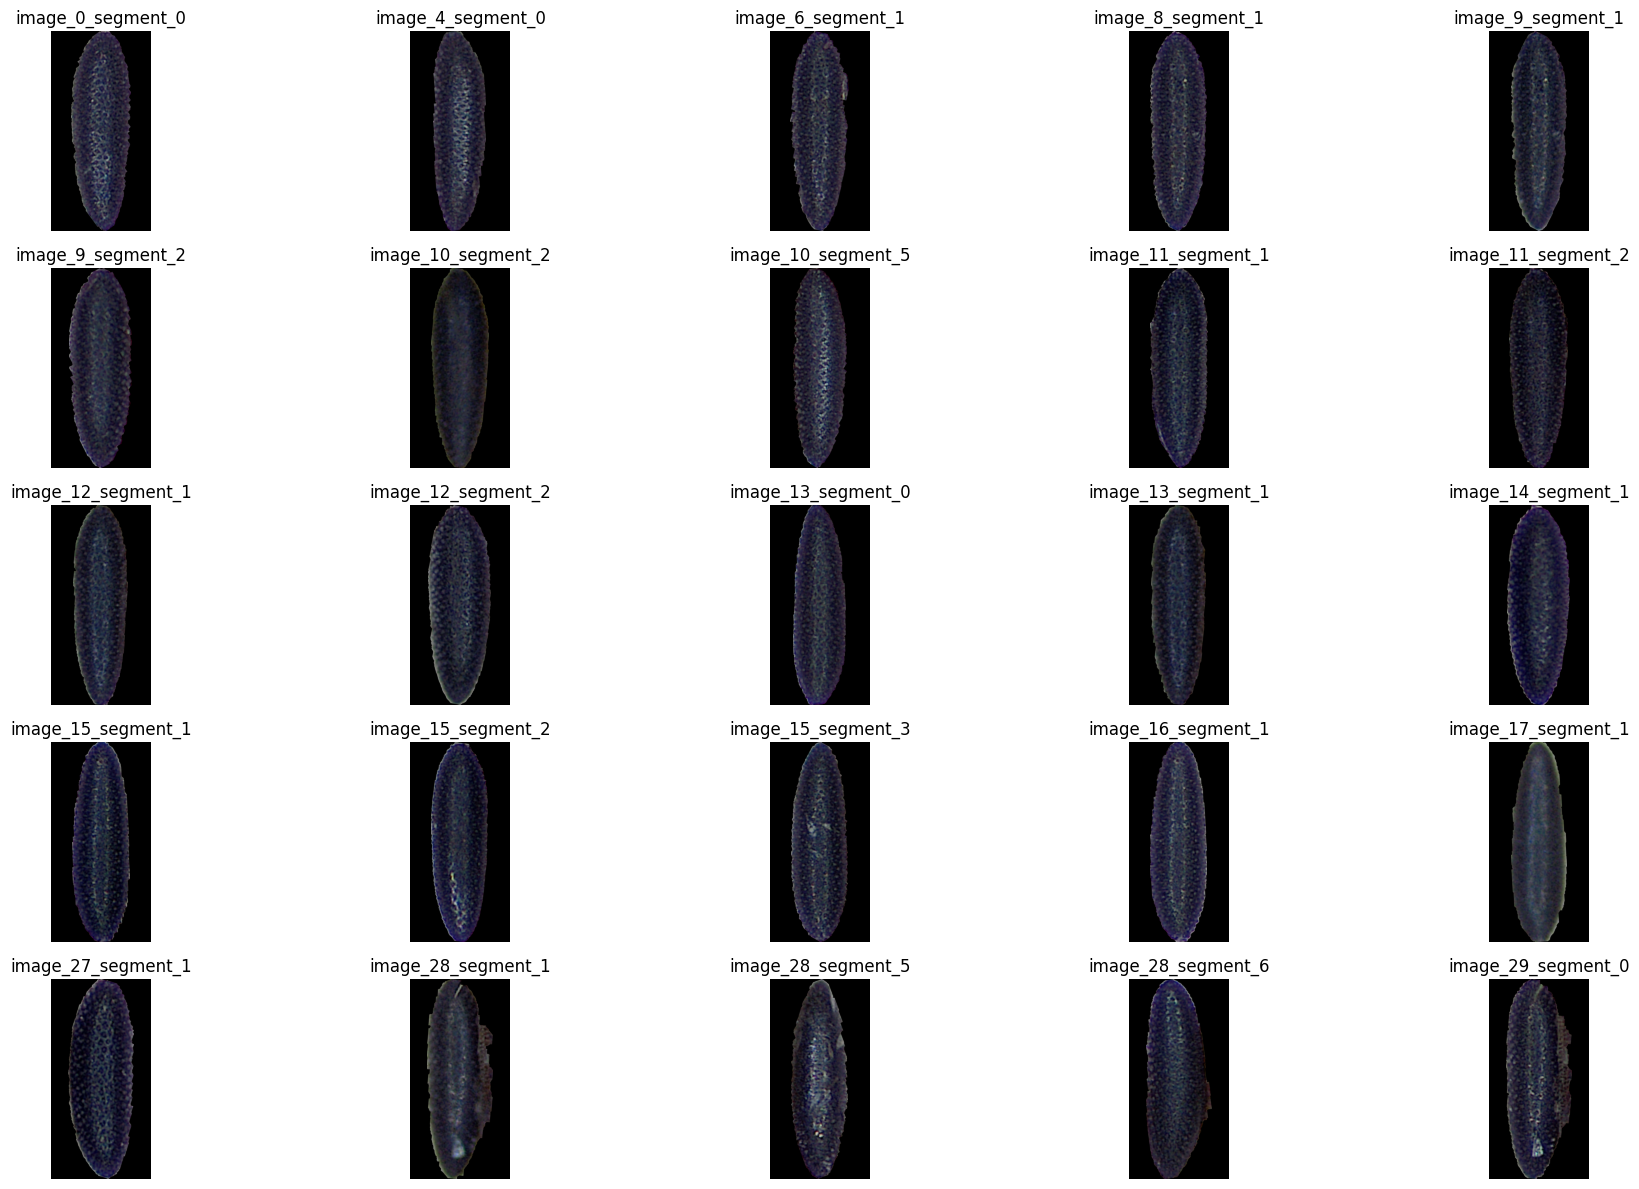

In [123]:
ecf.show_images(single_egg_df)

In [142]:
single_egg_df['sepcies'] = single_egg_df['species'].replace("aegypti_old", "aegypti")
single_egg_df['species'] = single_egg_df['species'].replace("albopictus_old", "albopictus")
train, test = train_test_split(single_egg_df, test_size=0.1)

In [187]:
X_train = train['segment']
X_train = np.stack(X_train.to_list()).astype(np.float32)
y_train = train['species']
X_test = test['segment']
X_test = np.stack(X_test.to_list()).astype(np.float32)
y_test = test['species']
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=0.1, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_ds = train_ds.shuffle(len(X_train_split)).batch(20).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_ds = val_ds.batch(20).prefetch(tf.data.AUTOTUNE)

In [166]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
# train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.shuffle(1000).batch(280/20).prefetch(tf.data.AUTOTUNE)

In [190]:
train_ds = ecf.prepare_dataset(X_train_split, y_train_split, 20)
val_ds = ecf.prepare_dataset(X_val_split, y_val_split, 20, shuffle=False)

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(200, 100, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [194]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5


2025-06-12 17:20:01.329815: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23839', 12 bytes spill stores, 12 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.2889 - loss: nan - val_accuracy: 0.2857 - val_loss: nan
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3169 - loss: nan - val_accuracy: 0.2857 - val_loss: nan
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3200 - loss: nan - val_accuracy: 0.2857 - val_loss: nan
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3156 - loss: nan - val_accuracy: 0.2857 - val_loss: nan
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3499 - loss: nan - val_accuracy: 0.2857 - val_loss: nan


In [176]:
print(type(X_train_split))           # sollte ndarray sein
print(type(X_train_split[0]))        # sollte ndarray sein
print(X_train_split[0].shape)        # z. B. (200, 100, 3)
print(X_train_split[0].dtype)        # float32 oder uint8

print(set(type(y) for y in y_train_split))   # sollte int oder np.int32 sein
print(set(type(x) for x in X_train_split))   # sollte ndarray sein


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(200, 100, 3)
float32
{<class 'numpy.ndarray'>}
{<class 'numpy.ndarray'>}


In [195]:
y_train_encoded[0].dtype

dtype('int64')

# MASK R-CNN